In [1]:
import pandas as pd
import numpy as np
import statistics as stats
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


## The model in this notebook uses Monte Carlo simulation to estimate annual cash flows and ending portfolio value.  
##
## I start with 10 years of actual historical adjusted close price on our portfolio. The simulated returns have a mean of 9.13 % and a standard deviation of 13.31, both of which are near but slightly below S&P historical averages.  The 99% confidence interval for nominal annual return is (0.23, 18.03).  The 95% interval is (1.745, 16.519).  There can be and are negative returns for some year/simulation tuples.
##
## The model incorporates income and capital gains taxes using 2024 rates, correctly computes portfolio drawdown due to Required Minimum Distributions, uses IRS.gov data to estimate social security benefits, and adds expected income from pensions and other income sources (currently 0). Per IRS, RMD start age is birth-year dependent.
## qlac and deferred fixed annuities are included using data from W & S
## critical illness and long term care insurance policies included using data from W & S
## Social security, annuities, and supplemental insurance can be turned on or off using separate boolean flags
##
## Inflation is incorporated using a random draw from array of BLS annual inflation rates 1974 ~ 2024
###  - inflation is compounded and applied to annual household expenses (which includes basic healthcare) as well as to annual critical illness and long term care expenses
##
## If annual expenses > income, then drawdown cash,then portfolio. No cash reserves are kept
###  - includes capital gains taxes on any drawdown, including for satisfying RMD
###  - tax is not optimized, ie portfolio drawdown is not used even if net taxes would be lowered  TBD
###  - RMD is always taken from the tax deferred accounts. Cash to cover capital gains is always taken from non-tax deferred accounts. Negative cash flow is taken first from cash, then from non-tax-deferred accounts.  Currently, brokerage and Roth tax-free accounts are not differentiated.
##
## Random draw for whether longterm care needed in a given year. 
###  - Gender-specific probability thresholds from AALTCI.org
###  - benefits and costs of long term care insurance from W & S
###
## Random draw for whether critical illness is needed in a given year. 
###  - Probability thresholds loosely derived from information found on the interweb
###  - benefits and costs of critical illness insurance from W & S
##
## TBD satisfy annual net income gap in a tax optimal manner between cash, tax deferred and post tax assets
## TBD need to improve handling tax on the different portfolio account types, or distinguishing source for portfolio drawdown.  Roth distributions would be tax free, for example.  Currently, all portfolio drawdowns are taxed as capital gains. Should study the impacts on legacy of paying capital gains and other cash requirements by selling brokerage account assets, paying taxes, but passing down Roth, versus covering cash requirements out of the Roth tax-free and passing down the residual from the brokerage accounts.  Depends on which is higher, capital gains tax rate versus inheritance tax.

In [ ]:
portfolio_data = pd.read_csv('./ActualPortfolioAdjustedClose02122024.csv')

In [ ]:
data_rows = portfolio_data.shape[0] - 1  # exclude header row
num_funds = portfolio_data.shape[1] - 1  # exclude date column
print('data shape: ' + str(portfolio_data.shape))
print('data rows: ' + str(data_rows))
print('number of funds: ' + str(num_funds))

In [ ]:
portfolio_prices = portfolio_data.iloc[:,1:num_funds+1]
portfolio_prices = portfolio_prices.values

In [ ]:
num_mc_sims = 10000
trade_days_per_year = 252
num_years = 30  #until kpb age 96
train_days = trade_days_per_year * num_years
np.random.seed(100)


In [ ]:
nrows=len(portfolio_prices)
portfolio_returns = portfolio_prices[1:nrows,:] / portfolio_prices[0:nrows-1,:]-1

In [ ]:
#current actual fund allocation from Fidelity
actual_weights = [0.0422, 0.0203, 0.1134, 0.0054, 0.0039, 0.1064, 0.0042, 0.0429, 0.0189, 0.0365, 
                  0.0694, 0.0432, 0.0664, 0.0355, 0.0639, 0.1363, 0.0609, 0.1301]

#alternative weighting strategies could be defined
equal_weights = 1. / num_funds
equal_risk = 2
max_sharpe_ratio = 3

#used so other allocation strategies can be defined above, then assigned here
portfolio_weights = np.array(actual_weights)


In [ ]:
   #start with the actual portfolio daily adjusted returns
portfolio_returns_cov = np.cov(np.transpose(portfolio_returns))
portfolio_returns_mean = np.mean(portfolio_returns, axis=0)
prm = np.full((train_days,num_funds),portfolio_returns_mean)   #fill matrix with mean value
prm = np.transpose(prm)  #transpose to use in inner producuct below


In [ ]:
   #placholder for the monte carlo returns
portfolio_returns_mc = np.full((train_days, num_mc_sims),0.)

In [ ]:

   #iterate over the number of simulations
   #create new returns data that is the sum of the portfolio return mean (prm) plus the random
for i in range (0, num_mc_sims):
       #create the random component from the distribution over the actual
    Z = np.random.normal(size=num_funds*train_days)
    Z = Z.reshape((num_funds, train_days))
    L = np.linalg.cholesky(portfolio_returns_cov)  #perform Cholesky decomposition

    daily_returns = prm + np.inner(L,np.transpose(Z)) #incorporate the random component into the actual

       #weight by actual portfolio asset allocation
       #convert to cumulative
       #retain in new matrix with shape days x num_mc_sims
       #portfolio_returns_mc (Monte Carlo) used below
    portfolio_returns_mc[:,i] = np.cumprod(np.inner(portfolio_weights,np.transpose(daily_returns))+1.)


In [ ]:
plt.plot(100. * (portfolio_returns_mc - 1.))
plt.ylabel('Portfolio Returns %')
plt.xlabel('Days')
plt.title('Simulated Returns over ' + str(train_days)  + ' Days')
plt.show()

In [ ]:
mean_return = np.mean(portfolio_returns_mc[-1,:]-1)
std_dev_returns = np.std(portfolio_returns_mc[-1,:]-1)
median_return = np.median(portfolio_returns_mc[-1,:]-1)

print('Mean Return: ' + f'{100. * mean_return:.2f}' + ' %')
print('Median Return: ' + f'{100. * median_return:.2f}' + ' %')


In [ ]:
print(np.quantile(portfolio_returns_mc[-1,:]-1, np.array([0.05, 0.95])))

In [ ]:
print(np.quantile(portfolio_returns_mc[-1,:]-1, [0.10]))

In [ ]:
print('Best return: ' + f'{100.*(portfolio_returns_mc[-1,np.argmax(portfolio_returns_mc[-1,:])] -1):.2f}' + ' %')

In [ ]:
print('Worst return: ' + f'{100.*(portfolio_returns_mc[-1,np.argmin(portfolio_returns_mc[-1,:])] -1):.2f}' + ' %')

In [ ]:
avg_annualized = 100. * (np.power(mean_return,1./num_years) -1.)
print('Average annualized return: ' + f'{avg_annualized:.4f}' + ' %')

In [ ]:
print(portfolio_returns_mc.shape)

In [ ]:
#ending values for all sims
final_day_mc = 100.*(portfolio_returns_mc[-1,:] - 1)
print(final_day_mc.shape)

In [ ]:
edges, bins = np.histogram(final_day_mc,bins=40)
plt.stairs(edges, bins)
#plt.hist(bins[:-1], bins, weights=counts)
plt.xlabel('Portfolio Returns %')
plt.ylabel('Simulation Count')
plt.title('Simulated Gross Total Return over ' + str(train_days/252)  + ' Years. No expenses or taxes.')
plt.show()

#log normal distribution?

In [ ]:
starting_value = 4.743642  #portfolio value in millions $

In [ ]:
#this plot ignores expenses and taxes.
#it's just the starting value times the (simulated) cumulative returns

ending_values = starting_value * (1. + final_day_mc/100.)
mean_ending_value = np.mean(ending_values)
mean_ending_value_str = "{:.2f}".format(mean_ending_value)

min_ending_value = np.min(ending_values)
min_ending_value_str = "{:.2f}".format(min_ending_value)

counts, bins = np.histogram(ending_values,bins=40)
plt.hist(bins[:-1], bins, weights=counts)
plt.xlabel('Portfolio Value ($ million)')
plt.ylabel('Simulation Count')
plt.title('Simulated (Gross) Total Value after ' + str(train_days/252)  + ' Years')

plt.plot([mean_ending_value],[400],'ro')
plt.annotate('Mean Ending Value: $' + str(mean_ending_value_str) + ' million', xy=(mean_ending_value, 400), xytext=(mean_ending_value + mean_ending_value/2., 500),
             arrowprops=dict(facecolor='red', shrink=0.05),
             )

plt.plot([min_ending_value],[100],'ro')
plt.annotate('Min Ending Value: $' + str(min_ending_value_str) + ' million', xy=(min_ending_value, 100), xytext=(min_ending_value + mean_ending_value/2., 250),
             arrowprops=dict(facecolor='red', shrink=0.05),
             )


plt.show()

## Now move from broadcasting to annual iteration so I can include ssa, pension, annuity, expenses taxes and RMD distributions

In [ ]:
#first, convert from daily to annual
cumulative_annual_returns = np.zeros([num_years,num_mc_sims])

for year in range(0,num_years):
    index = ((year + 1) * 252) - 1
    #print('year: ' + str(year) + ' ends at day: ' + str(index))
    cumulative_annual_returns[year,:] = portfolio_returns_mc[index,:]


In [ ]:
#backs out the cumprod performed above
annual_returns = np.zeros([num_years, num_mc_sims])
annual_returns[0,:] = cumulative_annual_returns[0,:] - 1.
for year in range(1,num_years):
    annual_returns[year,:] = (cumulative_annual_returns[year,:] / cumulative_annual_returns[year-1,:]) - 1.


   #write simulation annual returns to file so I don't have to regenerate every time
import pickle

annual_returns_mc_file = open('./annual_returns_mc',mode='wb')
pickle.dump(annual_returns, annual_returns_mc_file)
annual_returns_mc_file.close()


In [ ]:
# values from BLS 1974 ~ 2024 annual inflation
annual_inflation = np.array([ 
                    8.20833333333333, 9.29166666666667, 6.56666666666667,
                    6.25833333333333, 7.3, 9.71666666666667,
                    12.4333333333333, 10.4833333333333, 7.475,
                    3.93333333333333, 4.94166666666667, 4.375,
                    4.05833333333333, 4.125, 4.41666666666667,
                    4.51666666666667, 5.01666666666667, 4.9,
                    3.65, 3.30833333333333, 2.85,
                    2.99166666666667, 2.71666666666667, 2.39166666666667,
                    2.275, 2.08333333333333, 2.43333333333333,
                    2.65833333333333, 2.31666666666667, 1.45,
                    1.76666666666667, 2.16666666666667, 2.49166666666667,
                    2.325, 2.30833333333333, 1.69166666666667,
                    0.958333333333333, 1.66666666666667, 2.11666666666667,
                    1.75833333333333, 1.75, 1.825, 2.19166666666667,
                    1.85, 2.13333333333333, 2.2, 1.7, 3.575, 6.15, 4.775, 3.48])

avg_inf = 0.
cumulative_inf = 1.
random_inflation = np.zeros([num_years])

for year in range(0,num_years):
    random_inflation[year] = (annual_inflation[np.random.randint(0, annual_inflation.size)]) / 100.
    print('annual inflation: ' + "{:.2f}".format(100. * random_inflation[year]) + ' %')

    avg_inf += random_inflation[year]
    cumulative_inf *= 1. + random_inflation[year]

print(str(num_years) + ' year average: ' + "{:.2f}".format(100. * avg_inf/30.) + ' %')
print(str(num_years) + ' year compounded: ' + "{:.2f}".format(100. * cumulative_inf) + ' %')

   #write simulation annual inflation to file for reproducible what ifs
import pickle

random_inflation_file = open('./random_annual_inflation',mode='wb')
pickle.dump(random_inflation, random_inflation_file)
random_inflation_file.close()


In [217]:
ltc_probs = np.zeros(num_years)
ci_probs = np.zeros(num_years)

for year in range(0,num_years):
    ltc_probs[year] = np.random.rand() * 100.
    ci_probs[year] = np.random.rand() * 100.
    
probs = np.array([ltc_probs, ci_probs])

print(probs.shape)

probabilities_file = open('./random_supplemental_healthcare_probs_file',mode='wb')
pickle.dump(probs, probabilities_file)
probabilities_file.close()


(2, 30)


### What-if analyses can start with this cell if the random values for
### annual_returns_mc, inflation, and supplemental health havee already created and saved


In [60]:
import pandas as pd
import numpy as np
import statistics as stats
import matplotlib.pyplot as plt
import pickle

   #retrieve stored randomized annual returns
annual_returns_mc_file = open('./annual_returns_mc',mode='rb')
annual_returns = pickle.load(annual_returns_mc_file)
annual_returns_mc_file.close()
print(annual_returns.shape)

num_years = annual_returns.shape[0]
num_mc_sims = annual_returns.shape[1]
trade_days_per_year = 252
train_days = trade_days_per_year * num_years

   #retrieve stored annual randomized inflation
random_annual_inflation_file = open('./random_annual_inflation',mode='rb')
random_annual_inflation = pickle.load(random_annual_inflation_file)
random_annual_inflation_file.close()
print(np.mean(random_annual_inflation))

random_supplemental_healthcare_probs_file = open('./random_supplemental_healthcare_probs_file',mode='rb')
random_supplemental_healthcare_probs = pickle.load(random_supplemental_healthcare_probs_file)
random_supplemental_healthcare_probs_file.close()
print(random_supplemental_healthcare_probs)
ltc_probs = random_supplemental_healthcare_probs[0]
ci_probs = random_supplemental_healthcare_probs[1]


(30, 10000)
0.04258944444444444
[[98.37861513 36.42316217 74.92207382 17.62402273 15.2728581  13.33061971
  91.06568015 99.20531691 74.48989775  0.31690855  9.70180035 50.46854344
  14.60555399 75.5170149   4.29950599 65.00406253 86.47927869 17.50713572
  61.65466923 57.62084762 54.18897629  6.70697285 69.64198534 65.78424303
  28.03764512 78.99419031 34.36955606 67.00481177 55.99057553 74.99918652]
 [79.54686185 98.56595365 51.64497277 87.97635676 47.86116608 29.65892662
  34.38685809 52.70701488 97.72007517 18.75531472 39.87184054 22.74690327
  98.31549744 57.1687674  26.62130721 38.62906079 72.72789704  6.33393663
   3.75064878  0.35163336 63.01656833 38.67117563 46.56283895 29.96378488
  87.31326105 95.02899726 95.54865797 94.99700769 55.88111414 17.84337168]]


In [61]:
#hard coded 2024 tax brackets
       # NOTE: tax bracket depends on rmd, 
       # which depends on annual rate,  
       # which depends on sim.  
       # gross_income is a vector of length num_mc_sims
def get_tax_rate(gross_income):

    tax_rates = np.zeros([num_mc_sims])
    for sim in range(0,num_mc_sims):
        if(gross_income[sim] > 731200.):
            #print('37% tax bracket')
            tax_rates[sim] = 0.37
        elif(gross_income[sim] > 487451.):
            #print('35% tax bracket')
            tax_rates[sim] = 0.35 
        if(gross_income[sim] > 383901.):
            #print('32% tax bracket')
            tax_rates[sim] = 0.32
        elif(gross_income[sim] > 201051.):
            #print('24% tax bracket')
            tax_rates[sim] = 0.24
        elif(gross_income[sim] > 94301.):
            #print('22% tax bracket')
            tax_rates[sim] = 0.22
        elif(gross_income[sim] > 23201.):
            #print('12% tax bracket')
            tax_rates[sim] = 0.12
        elif(gross_income[sim] > 0.):
            #print('10% tax bracket')
            tax_rates[sim] = 0.1
        else:
            tax_rates[sim] = 0.0

    return tax_rates

### taxable income is per sim for portfolio growth, but scalar for drawdown
### 0.0 cg tax for negative annual growth
### doesn't harvest losses
def get_capital_gains_rate(taxable_income, growth):
    if isinstance(taxable_income, float) and isinstance(growth, float):
        cg = 0.0
        if(growth> 0.0 and taxable_income > 583750.):
            cg = 0.20
        elif(growth > 0.0 and taxable_income > 94051):
            cg = 0.15

        return cg
    else:
        cg = np.full([num_mc_sims], 0.)
        for sim in range(0,num_mc_sims):
            if(growth[sim] > 0.0 and taxable_income[sim] > 583750.):
                cg[sim] = 0.20
            elif(growth[sim] > 0.0 and taxable_income[sim] > 94051):
                cg[sim] = 0.15
                
        return cg
    

In [62]:
#FIXME paramaterize with ages and amounts
def get_ssa(year):
    ssa = 0.

    if(year > 3):
        ssa = 3500. + 3500.  #monthly when pil starts taking at 67
    elif (year > 1):
        ssa = 3500.          #monthly when kpb start taking at 67
        
    return ssa * 12.  #annual
    

In [63]:
def get_longterm_care_costs(is_male, age, long_term_care, prob):

    if(prob == 0.0):
        return False, 0

    costs = 0.
    if(long_term_care):
        costs = 100000.
    else:
        costs = 0.
        ltc = 100000.
        if(is_male):
            if(age > 89):
                if(prob > 49.9):
                    long_term_care = True
                    costs = ltc
            elif(age > 84):
                if(prob > 61.3):
                    long_term_care = True
                    costs = ltc
            elif(age > 79):
                if(prob > 75.7):
                    long_term_care = True
                    costs = ltc
            elif(age > 74):
                if(prob > 87.3):
                    long_term_care = True
                    costs = ltc
            elif(age > 69):
                if(prob > 94.7):
                    long_term_care = True
                    costs = ltc
        else: #else is female
            if(age > 89):
                if(prob > 41.7):
                    long_term_care = True
                    costs = ltc
            elif(age > 84):
                if(prob > 56.1):
                    long_term_care = True
                    costs = ltc
            elif(age > 79):
                if(prob > 72.8):
                    long_term_care = True
                    costs = ltc
            elif(age > 74):
                if(prob > 86.1):
                    long_term_care = True
                    costs = ltc
            elif(age > 69):
                if(prob > 94.4):
                    long_term_care = True
                    costs = ltc
    #if(long_term_care):
    #    print('long term care needed at age: ' + str(age) + ' $' + str(costs))

    return long_term_care, costs
        
### FIXME is critical illness gender specific?
def get_critical_illness_costs(age, critical_illness, prob):
    if(prob == 0.0):
        return False, 0
        
    costs = 0.
    if(age < 76):
        if(not critical_illness):
            if(prob > 0.95):  #  chance below age 76
                costs = 100000.
                critical_illness = True
        else:
            costs = 100000.
                
    elif(age < 86):
        if(not critical_illness):
            prob = np.random.rand()
            if(prob > 0.90):   #  chance below age 86
                costs = 100000.
                critical_illness = True
        else:
            costs = 100000.
    else:
        if(not critical_illness):
            prob = np.random.rand()
            if(prob > 0.85):   #   chance above age 86
                costs = 100000.
                critical_illness = True
        else:
            costs = 100000.
            
    #if(critical_illness):
    #    print('critical illness costs in year: ' + str(age) + ' $' + str(costs))
            
    return critical_illness,costs

#FIXME this dictionary lookup should protect against age index not found
# from Table III
def distribution_period(age):
    irs_distribution_dict = {
        73:26.5,
        74:25.5,
        75:24.6,
        76:23.7,
        77:22.9,
        78:22.0,
        79:21.1,
        80:20.2,
        81:19.4,
        82:18.5,
        83:17.7,
        84:16.8,
        85:16.0,
        86:15.2,
        87:14.4,
        88:13.7,
        89:12.9,
        90:12.2,
        91:11.5,
        92:10.8,
        93:10.1,
        94:9.5,
        95:8.9,
        96:8.4,
        97:7.8,
        98:7.3,
        99:6.8,
        100:6.4,
    }
    return irs_distribution_dict.get(age)
    
#FIXME num_mc_sims exposed global variable
#deferred_value is for one (previous) year-end, all sims
def compute_rmd(deferred_value, age, birth_year):
    rmd = np.zeros([num_mc_sims])
    
    threshold_age = 73
    if(birth_year > 1958):
        threshold_age = 75
        
    if(age >= threshold_age):   
        #print(' defered_value: '+ str(deferred_value) + ' distribution period: ' + str(distribution_period(age)))
        rmd = deferred_value / distribution_period(age)
    return rmd # rmd to subtract from portfolio and add to income

### FIXME assumes married filing jointly
def compute_standard_deduction(age1, age2):
    standard_deduction = 29250
    if(age1 > 64):
        standard_deduction += 1500

    if(age2 > 64):
        standard_deduction += 1500

    return standard_deduction


In [64]:
def get_qlac_income(age):
    qlac_income = 0.
    if(age >= 85):
        qlac_income = 90000.  #  $7,500 * 12
    
    return qlac_income

#FIXME could define and expect an annuity object that contains deferral period, duration, and payout
def get_annuity_income(age):
    annuity_income = 0.
    if(age >= 75 and age < 86):
        annuity_income = 42000.  # $3,500 * 12
        
    return annuity_income

### The Monte Carlo starts here

In [65]:
posttax_portfolio_value = 1139642.  #4743642.  #portfolio value in dollars $

In [66]:
import numpy as np  #so can start running at this cell

#fixed values
cash_reserves_start = 300000.
cash_reserves_emergency = 50000.
cash_reserves = np.full(num_mc_sims, (cash_reserves_start - cash_reserves_emergency))
cash_depleted = False  #currently a scalar global, should be per sim
cash_depletion_year = 1900
start_year = 2024

annual_cash_flow = np.zeros([num_years, num_mc_sims])

expenses = 10000. * 12.  #includes basic healthcare "essential discretionary"
pension = 1000. * 12. #IBM + Lockheed
kpb_age = 66
kpb_birth_year = 1958
pil_birth_year = 1960
pil_age = 64

include_longterm_care = False
kpb_need_longterm_care = False  #unless/until random draw sets it True
pil_need_longterm_care = False  #unless/until random draw sets it True
kpb_longterm_care_duration = 1
pil_longterm_care_duration = 1
longterm_care_costs = 0.
if(not include_longterm_care):
    ltc_probs = np.zeros(num_years)

include_critical_illness = False
critical_illness = False  #unless/until random draw sets it True
critical_illness_duration = 0
critical_illness_costs = 0.
if(not include_critical_illness):
    ci_probs = np.zeros(num_years)
    
include_deferred_annuity = False
include_pil_qlac = True
include_kpb_qlac = True

kpb_qlac_buy = 0.
pil_qlac_buy = 0.
annuity_buy = 0.
lifetime_other_income = 0.  #should also support rental income etc

include_longterm_care_ins = False
longterm_care_ins_premium = 0.0
longterm_care_ins_payout = 0.0
if(include_longterm_care_ins):
    longterm_care_ins_premium = 1300. * 12.
    longterm_care_ins_payout = 400000.  #* 2?
else:
    longterm_care_ins_premium = 0.
    longterm_care_ins_payout = 0.

include_critical_illness_ins = False
critical_illness_ins_premium = 0.0
critical_illness_ins_payout = 0.0
if(include_critical_illness_ins):
    critical_illness_ins_premium = 1000. * 12
    critical_illness_ins_payout = 100000.  #* 2?
else:
    critical_illnes_ins_premium = 0.
    critical_illness_ins_payout = 0.

if(include_deferred_annuity):
    annuity_buy = 279676.61
if(include_kpb_qlac):
    kpb_qlac_buy = 200000.
if(include_pil_qlac):
    pil_qlac_buy = 200000.

include_ssa = True
ssa= 0.  #annual income
ssa_benefits_rate = 1.  #use to reduce benefits
ssa_benefits_reduction_year = 35  #year to start benefits reduction
ssa_reduced_benefits_rate = .65

starting_value = posttax_portfolio_value   # brokerage accounts + Roth

kpb_deferred = np.zeros([num_years,num_mc_sims])
kpb_deferred[0,:] = 1254000. - kpb_qlac_buy #  - annuity_buy
pil_deferred = np.zeros([num_years,num_mc_sims])
pil_deferred[0,:] = 2350000. - pil_qlac_buy - annuity_buy
tax_free = np.zeros([num_years,num_mc_sims])
tax_free[0,:] = 300000. 

net_ending_values = np.zeros([num_years,num_mc_sims])
net_ending_values[0,:] = starting_value

print(' after tax starting value: ' + "${:,.2f}".format(starting_value))
print(' kpb tax-deferred starting value: ' + "${:,.2f}".format(kpb_deferred[0,0]))
print(' pil tax-deferred starting value: ' + "${:,.2f}".format(pil_deferred[0,0]))

salary = 50000.  #year 0 only, 1st quarter
compound_inf = 1.  #default starting inflation rate value

total_healthcare_expenses = 0.
total_healthcare_ins_payouts = 0.

print('include ssa: ' + str(include_ssa))
print('include longterm care costs: ' + str(include_longterm_care))
print('include longterm care insurance: ' + str(include_longterm_care))
print('include critical illness costs: ' + str(include_critical_illness))
print('include critical illness insurance: ' + str(include_critical_illness))
print('include deferred annuity: '  + str(include_deferred_annuity))
print('include pil qlac: ' + str(include_pil_qlac))
print('include kpb qlac: ' + str(include_kpb_qlac))
print('modeling years: ' + str(num_years))
print('modeling mc simulations: ' + str(num_mc_sims))
print('starting monthly expenses: ' + "${:,.2f}".format(expenses/12.))

#variable by year
for year in range(1, num_years):
    print('\nsimulation for year ' + str(start_year + year))
    
    kpb_age += 1
    pil_age += 1
    
    qlac_income = 0.
    annuity_income = 0.
    annual_other_income = 0.

    if(include_deferred_annuity):
        annuity_income = get_annuity_income(pil_age)
        
    if(include_kpb_qlac):
        qlac_income = get_qlac_income(kpb_age)
    if(include_pil_qlac):
        qlac_income += get_qlac_income(pil_age)
        
    if(include_ssa):
        if(year >= ssa_benefits_reduction_year):
            ssa_benefits_rate = ssa_reduced_benefits_rate
            print('reduced ssa benefits at: ' + str(ssa_benefits_rate * 100.) + ' %')
            
        ssa = ssa_benefits_rate * get_ssa(year)

    annual_other_income += (annuity_income + qlac_income)
    lifetime_other_income += annual_other_income
    
    last_years_returns = annual_returns[year-1,:]
    this_years_returns = annual_returns[year,:]
    print('average this year\'s returns: ' + "{:.2f}".format(100. * np.mean(this_years_returns)) + '%')
    
    kpb_rmd = compute_rmd(kpb_deferred[year-1,:],kpb_age, kpb_birth_year)
    pil_rmd = compute_rmd(pil_deferred[year-1,:],pil_age, pil_birth_year)
    rmd = kpb_rmd + pil_rmd

       #now apply this year's growth to the deferred account balances remaining after this year's RMD
    kpb_deferred[year,:] = (1. + this_years_returns)*(kpb_deferred[year-1,:] - kpb_rmd)
    pil_deferred[year,:] = (1. + this_years_returns)*(pil_deferred[year-1,:] - pil_rmd)

       #previous year-end, all sims
    starting = net_ending_values[year-1,:]
    
       #current year, all sims
    critical_illness, critical_illness_costs = get_critical_illness_costs(year, critical_illness, ci_probs[year])
    kpb_need_longterm_care, kpb_longterm_care_costs = get_longterm_care_costs(True, kpb_age, kpb_need_longterm_care,ltc_probs[year])
    pil_need_longterm_care, pil_longterm_care_costs = get_longterm_care_costs(False,pil_age, pil_need_longterm_care,ltc_probs[year])
    longterm_care_costs = kpb_longterm_care_costs + pil_longterm_care_costs
    if(kpb_need_longterm_care):
        kpb_longterm_care_duration += 1
        if(kpb_longterm_care_duration > 3):   #assumes 3 year duration of long term care event
            kpb_need_longterm_care = False
            kpb_long_termcare_duration = 0
            
        if(include_longterm_care_ins):
            include_longterm_care_ins = False  #onetime only?
            total_healthcare_ins_payouts += longterm_care_ins_payout
            cash_reserves[sim] += longterm_care_ins_payout
            print('longterm care insurance payout of: ' + "${:,.2f}".format(longterm_care_ins_payout))
            if(cash_depleted):
                cash_depleted = False

    if(pil_need_longterm_care):
        pil_longterm_care_duration += 1
        if(pil_longterm_care_duration > 3):  #assumes 3 year duration of long term care event
            pil_needlong_term_care = False
            pil_longterm_care_duration = 0

            #need this test for both if payout is one time only
        if(include_longterm_care_ins):
            include_longterm_care_ins = False  #onetime only?
            total_healthcare_ins_payouts += longterm_care_ins_payout
            cash_reserves[sim] += longterm_care_ins_payout
            print('longterm care insurance payout of: ' + "${:,.2f}".format(longterm_care_ins_payout))
            if(cash_depleted):
                cash_depleted = False

       #only models one per year right now FIXME
    if(critical_illness):
        critical_illness_duration += 1
        if(critical_illness_duration > 2):
            critical_illness_duration = 0
            critical_illness = False
        if(include_critical_illness_ins):
            #include_critical_illness_ins = False  #onetime only?
            total_healthcare_ins_payouts += critical_illness_ins_payout
            cash_reserves[sim] += critical_illness_ins_payout
            print('critical illness insurance payout of: ' + "${:,.2f}".format(critical_illness_ins_payout))
            if(cash_depleted):
                cash_depleted = False

       #random draw from historical annual inflation between 1974 and 2024 inclusive
    inf = 1. + random_annual_inflation[year]   #(annual_inflation[np.random.randint(0, annual_inflation.size)] / 100.)
    gross_income = salary + pension + ssa + annual_other_income + rmd
    taxable_income = gross_income - compute_standard_deduction(kpb_age, pil_age)
    income_tax = (taxable_income * get_tax_rate(gross_income))

       #allow negative returns to generate losses that reduce portfolio, but ignore for taxes for now ###FIXME
    capital_gains =  (starting * this_years_returns)
    cg_taxes = np.clip(capital_gains,a_min=0.0,a_max=None) * get_capital_gains_rate(taxable_income, capital_gains)

    print('salary: ' + "${:,.2f}".format(salary) + 
          ' pension: ' + "${:,.2f}".format(pension) + 
          ' ssa: ' + "${:,.2f}".format(ssa) + 
          ' other income: ' + "${:,.2f}".format(annual_other_income) + 
          ' rmd: ' + "${:,.2f}".format(rmd[0]) + 
          ' taxable income: ' + "${:,.2f}".format(taxable_income[0]) + 
          ' income tax: ' + "${:,.2f}".format(income_tax[0]))
    print('non-deferred starting value: ' + "${:,.2f}".format(starting[0]) + 
          ' returns: ' + "{:.2f}".format(100. * this_years_returns[0]) +
          '% capital gains: ' + "${:,.2f}".format(capital_gains[0]) +
          ' capital gains tax: ' + "${:,.2f}".format(cg_taxes[0]))

    basic_expenses = (compound_inf * expenses) + longterm_care_ins_premium + critical_illness_ins_premium
    healthcare_expenses = compound_inf * (critical_illness_costs + longterm_care_costs)
    total_healthcare_expenses += healthcare_expenses

    net_cash_flow = taxable_income - (income_tax + cg_taxes + basic_expenses + healthcare_expenses)
    print('net cash flow: ' + "${:,.2f}".format(net_cash_flow[0]))
    annual_cash_flow[year,:] = net_cash_flow
    
    #if net_cash_flow is negative, pay from cash or sell assets
    #else (re)invest surplus

    drawdown = np.full([num_mc_sims],0.)
    for sim in range(0, num_mc_sims):
        gap = 0.
        if(net_cash_flow[sim] < 0.0) :
            if(sim == 0):
                #print('negative cash flow for sim 0: ' + "${:,.2f}".format(net_cash_flow[0]))
                print('starting cash reserves: ' + "${:,.2f}".format(cash_reserves[0]))
            if((cash_reserves[sim] + net_cash_flow[sim]) >= 0.0):
                cash_reserves[sim] += net_cash_flow[sim]
                net_cash_flow[sim] = 0.0  # met through cash reserves drawdown
            else:
                gap = -(cash_reserves[sim] + net_cash_flow[sim])  #gap is a positive number
                cash_reserves[sim] = 0.0  # now depleted
                net_cash_flow[sim] = 0.0  # assumes entirely met through portfolio drawdown

                   #use non-tax-deferred to cover gap plus cg tax
                cg_tax = gap * get_capital_gains_rate(taxable_income[sim], gap)
                drawdown[sim] = (gap + cg_tax)  #drawdown gap plus capital gains taxes on the drawdown amount
                cg_taxes[sim] += cg_tax  #combine with cg tax on portfolio capital gains
                if(sim == 0):   
                    print('portfolio drawdown to cover negative cash flow: ' + "${:,.2f}".format(gap) + 
                          ' cg taxes: ' + "${:,.2f}".format(cg_tax) + 
                          ' total drawdown: ' + "${:,.2f}".format(drawdown[sim]))
                
                if(not cash_depleted):  #if it wasn't before, it is now!
                    cash_depleted = True
                    cash_depletion_year = year
        #else:
               #surplus available to invest
               #currently reinvests 100% of surplus. should I put some back into cash reserves?
    
    net_ending_values[year,:] = starting + capital_gains + net_cash_flow - drawdown
    print('starting value: ' + "${:,.2f}".format(starting[0]) + 
          ' capital gains: ' + "${:,.2f}".format(capital_gains[0]) + 
          ' net cash flow: ' + "${:,.2f}".format(net_cash_flow[0]) + 
          ' net ending value: ' + "${:,.2f}".format(net_ending_values[year,0])
         )
    
    print('basic expenses: ' + "${:,.2f}".format(basic_expenses) + 
          ' suplemental healthcare expenses: ' + "${:,.2f}".format(healthcare_expenses) + 
          ' income tax: ' + "${:,.2f}".format(income_tax[0]) + 
          ' total annual capital gains tax: ' + "${:,.2f}".format(cg_taxes[0]))

    print('simulated inflation:  ' + "{:.2f}".format(100. * (inf - 1.)) + ' %')
    compound_inf *= inf
    
      # ensure salary is zero after year 1
    salary = 0.0
#end of loop on years of simulation

if(cash_depleted):
    print('cash reserves deplete in year: ' + "{:.2f}".format(cash_depletion_year))
else:
    print('reached end of plan with remaining cash reserves.')
    
print('\ntotal compound inflation: ' + "{:.2f}".format(compound_inf))
print('supplemental healthcare expenses: ' + "${:,.2f}".format(total_healthcare_expenses))
print('supplemental healthcare insurance payouts: ' + "${:,.2f}".format(total_healthcare_ins_payouts))
print('supplemental income payouts: ' + "${:,.2f}".format(lifetime_other_income))


 after tax starting value: $1,139,642.00
 kpb tax-deferred starting value: $1,054,000.00
 pil tax-deferred starting value: $2,150,000.00
include ssa: True
include longterm care costs: False
include longterm care insurance: False
include critical illness costs: False
include critical illness insurance: False
include deferred annuity: False
include pil qlac: True
include kpb qlac: True
modeling years: 30
modeling mc simulations: 10000
starting monthly expenses: $10,000.00

simulation for year 2025
average this year's returns: 9.25%
salary: $50,000.00 pension: $12,000.00 ssa: $0.00 other income: $0.00 rmd: $0.00 taxable income: $29,750.00 income tax: $3,570.00
non-deferred starting value: $1,139,642.00 returns: 5.39% capital gains: $61,396.79 capital gains tax: $0.00
net cash flow: $-93,820.00
starting cash reserves: $250,000.00
starting value: $1,139,642.00 capital gains: $61,396.79 net cash flow: $0.00 net ending value: $1,201,038.79
basic expenses: $120,000.00 suplemental healthcare ex

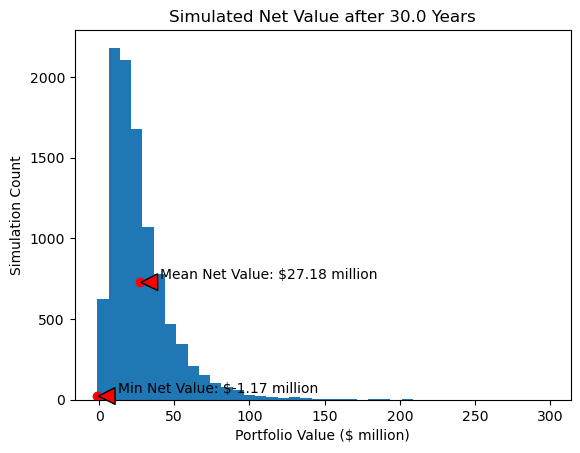

In [67]:
#ending_values = starting_value * (1. + final_day_mc/100.)
million = 1000000.
ev = (net_ending_values[-1,:] + kpb_deferred[-1,:] + pil_deferred[-1,:])/ million  #scale back to millions
mean_ending_value = np.mean(ev)
mean_ending_value_str = "{:.2f}".format(mean_ending_value)

min_ending_value = np.min(ev)
min_ending_value_str = "{:.2f}".format(min_ending_value)

counts, bins = np.histogram(ev,bins=40)
plt.hist(bins[:-1], bins, weights=counts)
plt.xlabel('Portfolio Value ($ million)')
plt.ylabel('Simulation Count')
plt.title('Simulated Net Value after ' + str(train_days/252)  + ' Years')

xcoord = np.max(counts)/3
plt.plot([mean_ending_value],[xcoord],'ro')
plt.annotate('Mean Net Value: $' + str(mean_ending_value_str) + ' million', xy=(mean_ending_value, xcoord), xytext=(mean_ending_value + mean_ending_value/2., xcoord + 20),
             arrowprops=dict(facecolor='red', shrink=0.05),
             )
xcoord = np.max(counts)/ 100
plt.plot([min_ending_value],[xcoord],'ro')
plt.annotate('Min Net Value: $' + str(min_ending_value_str) + ' million', xy=(min_ending_value, xcoord), xytext=(min_ending_value + mean_ending_value/2., xcoord +20),
             arrowprops=dict(facecolor='red', shrink=0.05),
             )

plt.show()

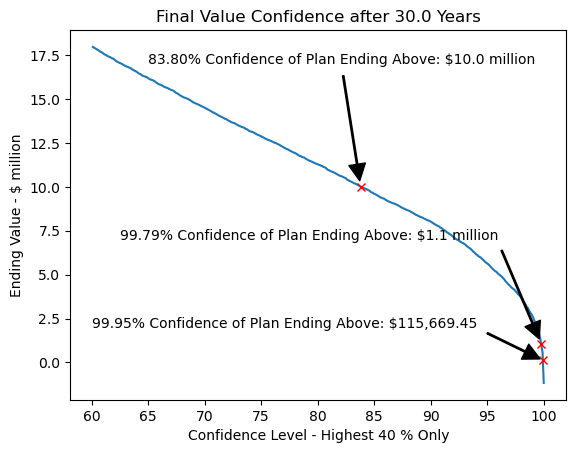

In [68]:

#build some arrays for plotting

xs = np.zeros([400])
ys = np.zeros([400])
for i in range(0,400):
    percent = i / 10.
    xs[i] = 100. - percent
    ys[i] = np.percentile(ev,percent)

plt.title('Final Value Confidence after ' + str(train_days/252)  + ' Years')
plt.xlabel('Confidence Level - Highest 40 % Only')
plt.ylabel('Ending Value - $ million')
plt.plot(xs,ys)

# find the percent at which the ending value goes negative
tgt_value = 0.0
xval = (ev<tgt_value).mean()
yval = np.quantile(ev,xval)
xval = 100. * (1. - xval)
plt.plot(xval,yval,'rx')
xval_str = "{:.2f}".format(xval)
yval_str = "{:,.2f}".format(1000000. * yval) #convert to dollars

plt.annotate(xval_str + '% Confidence of Plan Ending Above: $' + yval_str + ' ', xy=(xval, yval), xytext=(60,2),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1),
             )

# find the percent at which the ending value ia $10 million
tgt_value = 1.0
xval = (ev<tgt_value).mean()
yval = np.quantile(ev,xval)
xval = 100. * (1. - xval)
plt.plot(xval,yval,'rx')
xval_str = "{:.2f}".format(xval)
yval_str = "{:,.1f}".format(yval) #convert to dollars

plt.annotate(xval_str + '% Confidence of Plan Ending Above: $' + yval_str + ' million', xy=(xval, yval), xytext=(62.5,7),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1),
             )


# find the percent at which the ending value ia $10 million
tgt_value = 10.0
xval = (ev<tgt_value).mean()
yval = np.quantile(ev,xval)
xval = 100. * (1. - xval)
plt.plot(xval,yval,'rx')
xval_str = "{:.2f}".format(xval)
yval_str = "{:,.1f}".format(yval) #convert to dollars

plt.annotate(xval_str + '% Confidence of Plan Ending Above: $' + yval_str + ' million', xy=(xval, yval), xytext=(65,17),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1),
             )

plt.show()


In [69]:
xval = (ev<tgt_value).mean()
yval = np.quantile(ev,xval)
print(100* 1. - xval)
print(yval)

99.838
10.007119414230933


In [70]:
yval = np.quantile(ev,.01)
print(yval)

2.6543498523357427


In [71]:
from scipy.stats import t

data = ev
mean = np.mean(data)
std = np.std(data, ddof=0)
confidence_level = 0.995
n = len(data)
degrees_of_freedom = n - 1
t_critical = np.abs(t.ppf((1 - confidence_level) / 2, degrees_of_freedom))
margin_of_error = t_critical * (std / np.sqrt(n))
lower_bound = mean - margin_of_error
upper_bound = mean + margin_of_error
print('For ending portfolio value')
print(f"The {confidence_level * 100:.2f}% confidence interval is: ({lower_bound:.2f}, {upper_bound:.2f})")

confidence_level = 0.9999
n = len(data)
degrees_of_freedom = n - 1
t_critical = np.abs(t.ppf((1 - confidence_level) / 2, degrees_of_freedom))
margin_of_error = t_critical * (std / np.sqrt(n))
lower_bound = mean - margin_of_error
upper_bound = mean + margin_of_error
print(f"The {confidence_level * 100:.2f}% confidence interval is: ({lower_bound:.2f}, {upper_bound:.2f})")


For ending portfolio value
The 99.50% confidence interval is: (26.58, 27.79)
The 99.99% confidence interval is: (26.35, 28.02)


### Above this was analysis of expected portfolio value
### Below this is analyis of cash flow

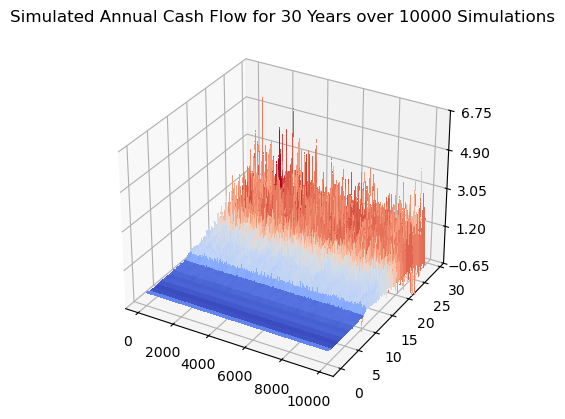

In [72]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
Y = np.arange(0, num_years, 1)
X = np.arange(0, num_mc_sims, 1)
X, Y = np.meshgrid(X, Y)
Z = annual_cash_flow /1000000.

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-.650000, 6.750000)
ax.zaxis.set_major_locator(LinearLocator(5))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.25, aspect=10)

plt.title('Simulated Annual Cash Flow for ' + str(num_years) + ' Years over ' + str(num_mc_sims) + ' Simulations')


plt.show()

In [73]:
print(np.max(annual_cash_flow))
print(np.min(annual_cash_flow))


5858553.008906085
-5010781.936609957


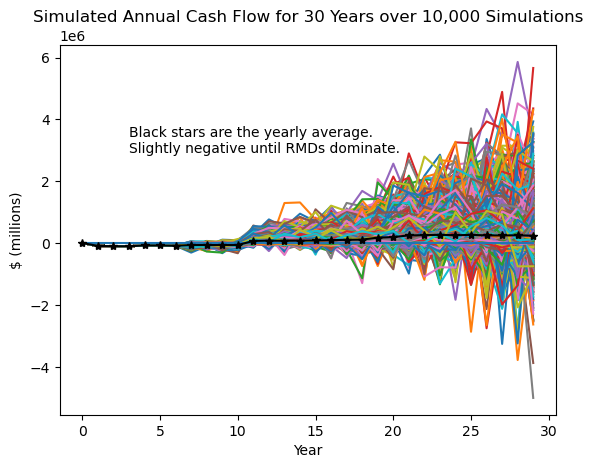

In [74]:
y = np.full([num_years],0)

plt.plot(annual_cash_flow)
plt.plot(y[0:num_years])

ymean = np.mean(annual_cash_flow,axis=1)
plt.plot(ymean,color='black',marker='*')

plt.title('Simulated Annual Cash Flow for 30 Years over 10,000 Simulations')
plt.xlabel('Year')
plt.ylabel('$ (millions)')

plt.annotate('Black stars are the yearly average.\nSlightly negative until RMDs dominate.',xy=(3,np.max(annual_cash_flow) / 2.))

plt.show()

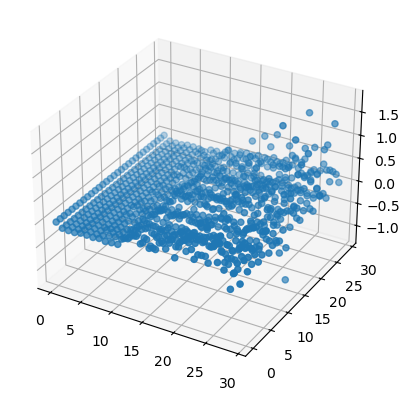

In [75]:
from mpl_toolkits.mplot3d import Axes3D
# Create a figure and 3D axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y = np.mgrid[0:num_years:1, 0:num_years:1]
z = annual_cash_flow #/ 1000000.

ax.scatter(x,y,z[0:num_years,0:num_years],marker='o')
plt.show()

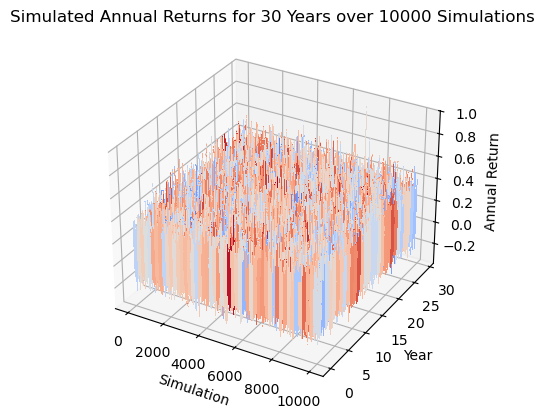

In [76]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
Y = np.arange(0, num_years, 1)
X = np.arange(0, num_mc_sims, 1)
X, Y = np.meshgrid(X, Y)
Z = annual_returns

 #Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.title('Simulated Annual Returns for ' + str(num_years) + ' Years over ' + str(num_mc_sims) + ' Simulations')
# Add labels to the axes
ax.set_xlabel('Simulation')
ax.set_ylabel('Year')
ax.set_zlabel('Annual Return')
plt.show()

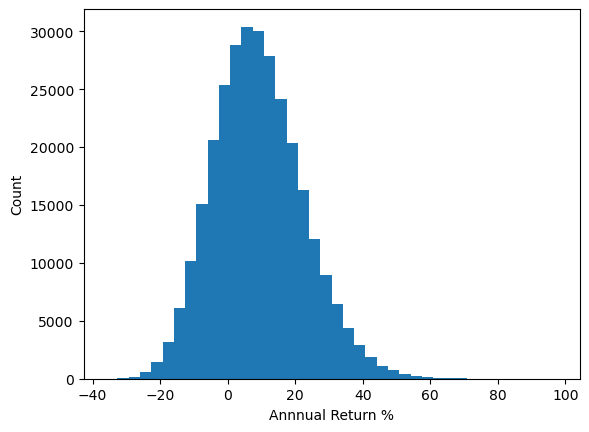

In [77]:
counts, bins = np.histogram(annual_returns * 100.,bins=40)
plt.hist(bins[:-1], bins, weights=counts)
plt.xlabel('Annnual Return %')
plt.ylabel('Count')
plt.show()

In [78]:
np.mean(annual_returns * 100.)

np.float64(9.131865081513563)

In [79]:
np.std(annual_returns * 100.)

np.float64(13.317364502828962)

In [80]:

data = annual_returns * 100.
mean = np.mean(data)
std = np.std(data, ddof=1)
confidence_level = 0.995
n = len(data)
degrees_of_freedom = n - 1
t_critical = np.abs(t.ppf((1 - confidence_level) / 2, degrees_of_freedom))
margin_of_error = t_critical * (std / np.sqrt(n))
lower_bound = mean - margin_of_error
upper_bound = mean + margin_of_error
print('For annual cash flow')
print(f"The {confidence_level * 100:.2f}% confidence interval is: ({lower_bound:.3f}, {upper_bound:.3f})")

confidence_level = 0.999
n = len(data)
degrees_of_freedom = n - 1
t_critical = np.abs(t.ppf((1 - confidence_level) / 2, degrees_of_freedom))
margin_of_error = t_critical * (std / np.sqrt(n))
lower_bound = mean - margin_of_error
upper_bound = mean + margin_of_error
print(f"The {confidence_level * 100:.2f}% confidence interval is: ({lower_bound:.2f}, {upper_bound:.2f})")



For annual cash flow
The 99.50% confidence interval is: (1.745, 16.519)
The 99.90% confidence interval is: (0.23, 18.03)



### Parking Lot below
